# Loading and cleaining

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from xgboost import XGBRegressor 
from xgboost import plot_importance
import pylab as pl
from sklearn.cross_validation import train_test_split
from scipy import stats
from scipy.stats import norm

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
df = pd.read_csv('data_input.csv', sep=';', index_col='Inst ID', thousands=',')
df['avg short'] = df['avg short'].apply(lambda x: x.replace(',','.'))
df['avg waste'] = df['avg waste'].apply(lambda x: x.replace(',','.'))
df.head(50)

,L,mu,cvr,f,m,cs/cw,S,costs,LB 95% CI,UB 95% CI,avg short,avg waste
Inst ID,,,,,,,,,,,,
1,0,2,5,0%,3,1,2,310.0,308.0,312.0,11.6%,0.4%
22,0,2,5,50%,3,1,2,242.0,241.0,243.0,10.9%,0.1%
23,0,2,5,50%,3,2,3,367.0,364.0,370.0,0.8%,1.7%
24,0,2,5,50%,3,5,3,414.0,411.0,418.0,0.8%,1.7%
25,0,2,5,50%,3,1,3,493.0,489.0,497.0,0.8%,1.7%
27,0,2,5,50%,3,5,3,1120.0,1110.0,1130.0,0.8%,1.7%
30,0,2,5,50%,4,2,3,87.4,86.0,88.7,0.8%,0.3%
31,0,2,5,50%,4,5,3,134.0,133.0,136.0,0.8%,0.3%
32,0,2,5,50%,4,1,3,213.0,210.0,215.0,0.8%,0.3%


In [8]:
df.drop(['costs','LB 95% CI','UB 95% CI'], axis=1, inplace=True)
df['f'] = df['f'].str.rstrip('%').astype('float') / 100.0
df['avg short'] = df['avg short'].str.rstrip('%').astype('float')
df['avg waste'] = df['avg waste'].str.rstrip('%').astype('float')

In [9]:
df['m*l'] = df['m']*df['L']
df['m*mu'] = df['m']*df['mu']
df['m*cvr'] = df['cvr']*df['m']
df['m*f']= df['m']*df['f']
df['m*cs/cw']= df['m']*df['cs/cw']

df['l*mu'] = df['mu']*df['L']
df['l*cvr']=df['L']*df['cvr']
df['l*f']=df['L']*df['f']
df['l*cs/cw']=df['L']*df['cs/cw']

df['mu*cvr']=df['mu']*df['cvr']
df['mu*f']=df['mu']*df['f']
df['mu*cs/cw']=df['mu']*df['cs/cw']

df['cvr*f']=df['cvr']*df['f']
df['cvr*cs/cw']=df['cvr']*df['cs/cw']

df['cs/cw*f']=df['cs/cw']*df['f']

#create second file with transformed target variable
#df2 = df
#df2['log avg short'] = np.log(df2['avg short'])


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


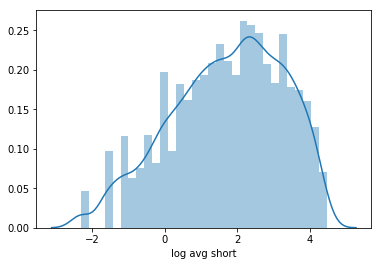

In [5]:
# df2 = df2.replace([np.inf, -np.inf], np.nan)
# df2 = df2.dropna()
# sns.distplot(df2['log avg short']);

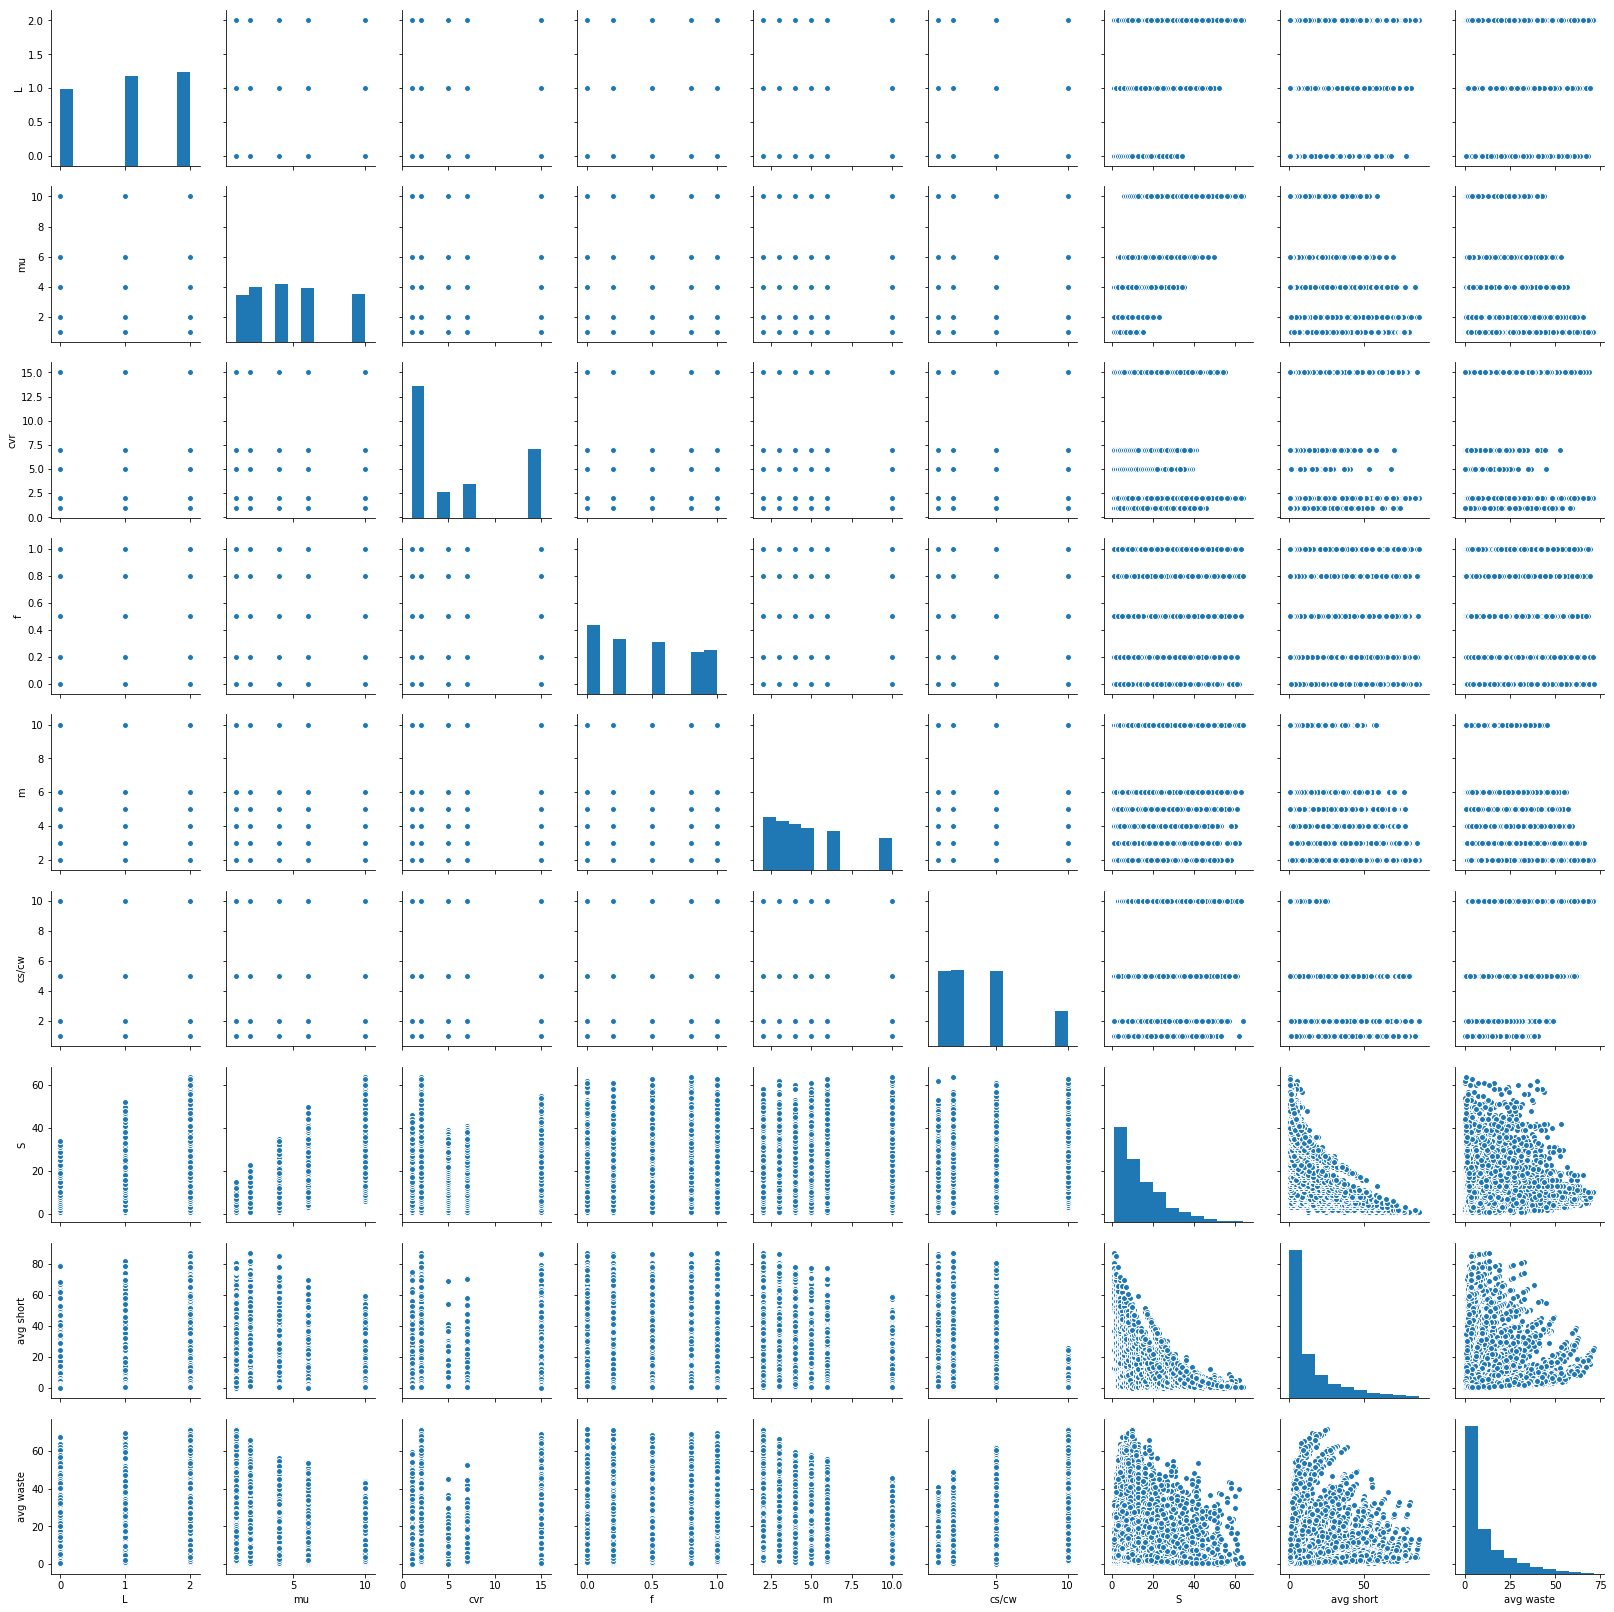

In [5]:
#Analyze the feature relations
sns.pairplot(df)

In [10]:
#See what features have abnormal distributions
df.describe()

,L,mu,cvr,f,m,cs/cw,S,avg short,avg waste,m*l,...,l*mu,l*cvr,l*f,l*cs/cw,mu*cvr,mu*f,mu*cs/cw,cvr*f,cvr*cs/cw,cs/cw*f
count,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,...,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000
mean,1.064737,4.563969,6.172357,0.436645,4.588659,3.627761,13.612286,13.743426,10.890880,4.927348,...,4.897933,6.548966,0.470242,3.885411,28.508447,1.884111,16.334908,2.706568,22.436976,1.570715
std,0.807465,3.101154,5.647150,0.370346,2.401306,2.941700,10.899727,17.204928,13.007076,4.947961,...,5.590760,8.894811,0.614090,4.935894,36.551437,2.280929,19.338229,4.076625,32.462965,2.131386
min,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.100000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,0.000000,2.000000,2.000000,0.000000,3.000000,1.000000,5.000000,1.900000,1.700000,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,4.000000,0.000000,4.000000,0.000000
50%,1.000000,4.000000,2.000000,0.500000,4.000000,2.000000,11.000000,6.400000,5.500000,4.000000,...,4.000000,2.000000,0.200000,2.000000,14.000000,1.000000,10.000000,1.000000,10.000000,1.000000
75%,2.000000,6.000000,15.000000,0.800000,6.000000,5.000000,19.000000,18.700000,15.100000,8.000000,...,8.000000,10.000000,1.000000,5.000000,30.000000,3.000000,20.000000,3.000000,30.000000,2.000000
max,2.000000,10.000000,15.000000,1.000000,10.000000,10.000000,64.000000,87.100000,71.800000,20.000000,...,20.000000,30.000000,2.000000,20.000000,150.000000,10.000000,100.000000,15.000000,150.000000,10.000000


# Exploration

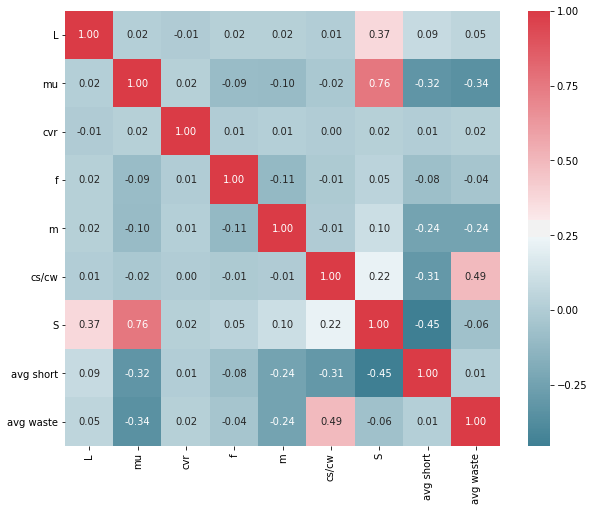

In [61]:
def correlation_plot():
    f, ax = pl.subplots(figsize=(10, 8))

    corr = df[['L', 'mu', 'cvr', 'f', 'm', 'cs/cw','S', 'avg short', 'avg waste']].corr() 
                         
    return sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), annot=True, fmt=".2f", cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)

correlation_plot()

In [36]:
#sns.set()
#sns.pairplot(df,hue="avg short")

# Model training

In [11]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Predicting S

In [33]:
# Loading example data
X_s = df.drop(['S', 'avg short', 'avg waste'],1)
y_s = np.array(df['S'])

# Training regressor
rf = RandomForestRegressor(n_estimators = 100, random_state = 0)
ada = AdaBoostRegressor()
xgb = XGBRegressor(colsample_bytree= 0.5, learning_rate=0.1, max_depth= 5, min_child_weight= 10, 
                    n_estimators= 1000, nthread= 4, objective= 'reg:linear', silent= 1, subsample= 0.5)
lr = LinearRegression()

#evaluate the regressor
labels = ['RandomForestRegressor', 'AdaBoostRegressor', 'XGBRegressor','LinearRegression']

for regr, label in zip([rf, ada, xgb, lr], labels):

    scores_mse = cross_val_score(regr, X_s, y_s, 
                                cv=10, 
                                scoring='neg_mean_squared_error')
    print("MSE: %0.3f (+/- %0.4f) [%s]"% (scores_mse.mean(), scores_mse.std(), label))
    
    scores_mae = cross_val_score(regr, X_s, y_s, 
                                cv=10, 
                                scoring='neg_mean_absolute_error')
    print("MAE: %0.3f (+/- %0.4f) [%s]"% (scores_mae.mean(), scores_mae.std(), label))

#fit the model
rf = rf.fit(X_s,y_s)
ada = ada.fit(X_s,y_s)
xgb = xgb.fit(X_s,y_s)
lr = lr.fit(X_s,y_s)


MSE: -26.027 (+/- 34.5155) [RandomForestRegressor]
MAE: -3.465 (+/- 2.4069) [RandomForestRegressor]
MSE: -33.386 (+/- 29.8182) [AdaBoostRegressor]
MAE: -4.482 (+/- 1.7468) [AdaBoostRegressor]
MSE: -14.583 (+/- 21.6309) [XGBRegressor]
MAE: -2.628 (+/- 1.7506) [XGBRegressor]
MSE: -12.122 (+/- 9.5787) [LinearRegression]
MAE: -2.686 (+/- 0.9932) [LinearRegression]


# Predicting avg short

In [55]:
# Loading example data
X_short = df.drop(['S', 'avg short', 'avg waste'],1)
y_short = np.array(df['avg short'])

# Training regressor
rf1 = RandomForestRegressor(n_estimators = 100, random_state = 0)
ada1 = AdaBoostRegressor()
xgb1 = XGBRegressor(colsample_bytree= 0.5, learning_rate=0.1, max_depth= 5, min_child_weight= 10, 
                    n_estimators= 500, nthread= 4, objective= 'reg:linear', silent= 1, subsample= 0.7)
lr1 = LinearRegression()

#evaluate the regressor
labels = ['RandomForestRegressor', 'AdaBoostRegressor', 'XGBRegressor','LinearRegression']

for regr, label in zip([rf1, ada1, xgb1, lr1], labels):

    scores_mse = cross_val_score(regr, X_short, y_short, 
                                cv=10, 
                                scoring='neg_mean_squared_error')
    print("MSE: %0.3f (+/- %0.4f) [%s]"% (scores_mse.mean(), scores_mse.std(), label))
    
    scores_mae = cross_val_score(regr, X_short, y_short, 
                                cv=10, 
                                scoring='neg_mean_absolute_error')
    print("MAE: %0.3f (+/- %0.4f) [%s]"% (scores_mae.mean(), scores_mae.std(), label))

#fit the model
rf1 = rf1.fit(X_short,y_short)
ada1 = ada1.fit(X_short,y_short)
xgb1 = xgb1.fit(X_short,y_short)
lr1 = lr1.fit(X_short,y_short)

MSE: -107.057 (+/- 58.4991) [RandomForestRegressor]
MAE: -7.167 (+/- 2.2712) [RandomForestRegressor]
MSE: -181.833 (+/- 54.9962) [AdaBoostRegressor]
MAE: -11.863 (+/- 1.7224) [AdaBoostRegressor]
MSE: -106.858 (+/- 59.7476) [XGBRegressor]
MAE: -7.215 (+/- 2.2922) [XGBRegressor]
MSE: -222.871 (+/- 95.8730) [LinearRegression]
MAE: -10.947 (+/- 2.0574) [LinearRegression]


# Predicting avg waste

In [56]:
# Loading example data
X_waste = df.drop(['S', 'avg short', 'avg waste'],1)
y_waste = np.array(df['avg waste'])

# Training regressor
rf2 = RandomForestRegressor(n_estimators = 100, random_state = 0)
ada2 = AdaBoostRegressor()
xgb2 = XGBRegressor(colsample_bytree= 0.5, learning_rate=0.1, max_depth= 5, min_child_weight= 10, 
                    n_estimators= 500, nthread= 4, objective= 'reg:linear', silent= 1, subsample= 0.7)
lr2 = LinearRegression()

#evaluate the regressor
labels = ['RandomForestRegressor', 'AdaBoostRegressor', 'XGBRegressor','LinearRegression']

for regr, label in zip([rf2, ada2, xgb2, lr2], labels):

    scores_mse = cross_val_score(regr, X_waste, y_waste, 
                                cv=10, 
                                scoring='neg_mean_squared_error')
    print("MSE: %0.3f (+/- %0.4f) [%s]"% (scores_mse.mean(), scores_mse.std(), label))
    
    scores_mae = cross_val_score(regr, X_waste, y_waste, 
                                cv=10, 
                                scoring='neg_mean_absolute_error')
    print("MAE: %0.3f (+/- %0.4f) [%s]"% (scores_mae.mean(), scores_mae.std(), label))

#fit the model
rf2 = rf2.fit(X_waste,y_waste)
ada2 = ada2.fit(X_waste,y_waste)
xgb2 = xgb2.fit(X_waste,y_waste)
lr2 = lr2.fit(X_waste,y_waste)

MSE: -41.033 (+/- 20.5298) [RandomForestRegressor]
MAE: -4.689 (+/- 1.3324) [RandomForestRegressor]
MSE: -78.606 (+/- 21.2613) [AdaBoostRegressor]
MAE: -7.787 (+/- 0.9578) [AdaBoostRegressor]
MSE: -38.588 (+/- 19.7646) [XGBRegressor]
MAE: -4.535 (+/- 1.3413) [XGBRegressor]
MSE: -101.549 (+/- 37.6245) [LinearRegression]
MAE: -7.743 (+/- 1.3665) [LinearRegression]


In [36]:
def plotCoefficients(model, X):
    """
        Plots sorted coefficient values of the model
    """
    try:
        coefs = pd.DataFrame(model.coef_, X.columns)
    except:
        coefs = pd.DataFrame(model.feature_importances_, X.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    pl.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    pl.grid(True, axis='y')
    pl.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

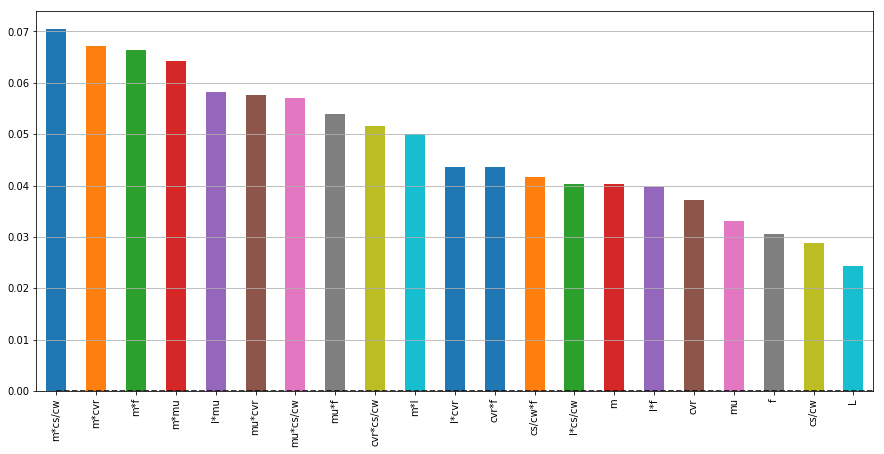

In [43]:
plotCoefficients(xgb, X_s)

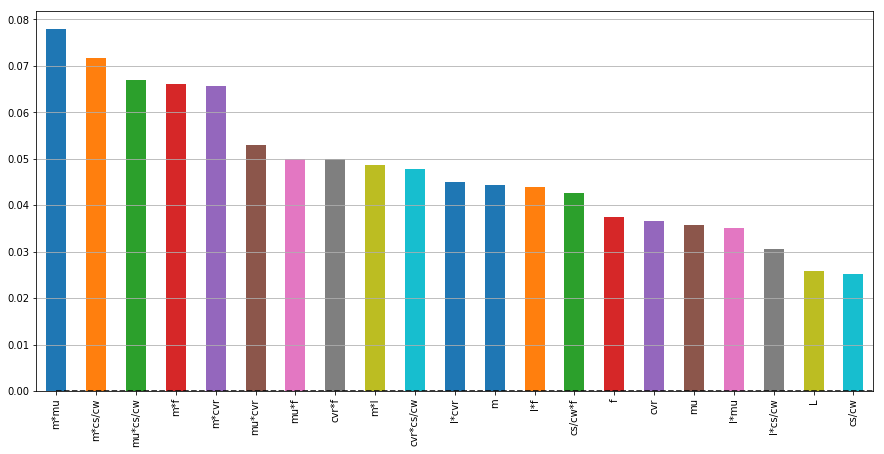

In [44]:
plotCoefficients(xgb1, X_short) #X_short and X_waste

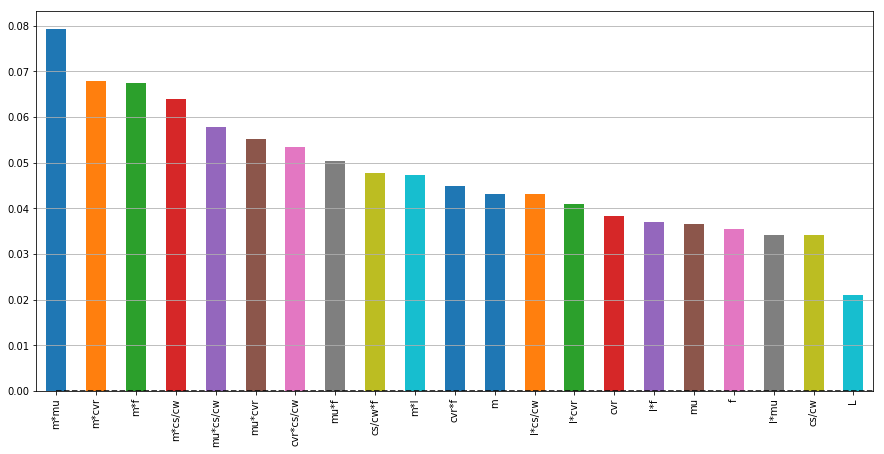

In [45]:
plotCoefficients(xgb2, X_waste) #X_short and X_waste

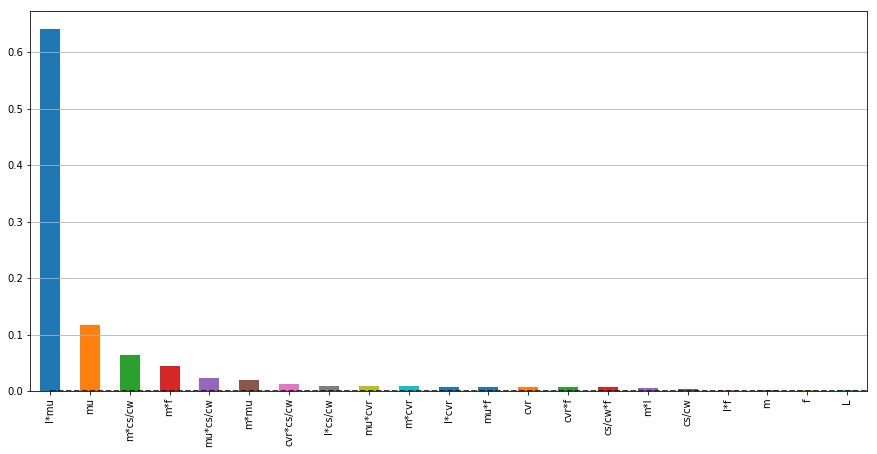

In [46]:
plotCoefficients(rf, X_s)

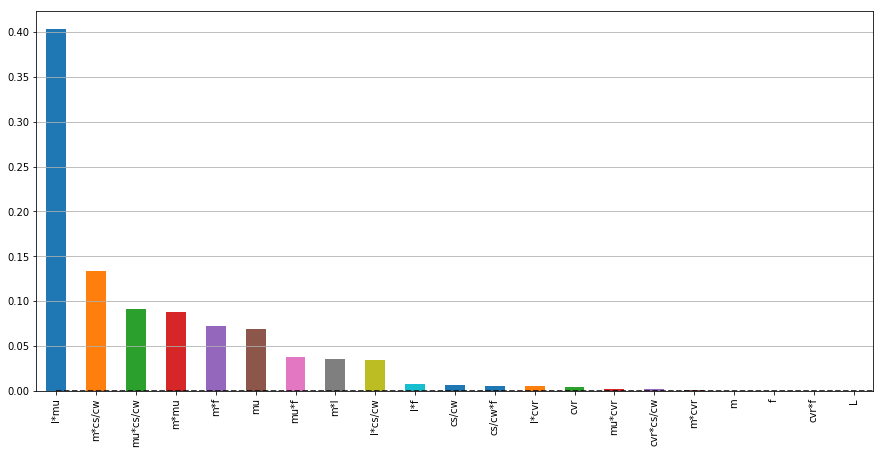

In [47]:
plotCoefficients(ada, X_s)

# Grid search to find the most optimal hyperparameters

In [11]:
from sklearn.model_selection import GridSearchCV

xgb1 = XGBRegressor()
parameters = {'nthread':[4, 6], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.1], #so called `eta` value
              'max_depth': [5, 7, 10],
              'min_child_weight': [4,7,10],
              'silent': [1, 3],
              'subsample': [0.5, 0.7],
              'colsample_bytree': [0.3, 0.5],
              'n_estimators': [500, 1000]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(X,y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 10.8min finished


0.64593287840801
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


# Check performance

In [63]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_waste, y_waste, random_state=1, test_size=0.1) #X_s, X_short, X_waste

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (7618, 21)
Training Labels Shape: (7618,)
Testing Features Shape: (847, 21)
Testing Labels Shape: (847,)


In [64]:
def plot_joint_and_r_squared(model, X_train=X_train, X_test=X_test):
    prediction_model = (model.predict(X_test))
    d = {'model_prediction': prediction_model, 'true_value': (y_test)}
    df = pd.DataFrame(data=d)
    sns.jointplot(x="model_prediction", y="true_value", data=df, kind="reg").fig.set_figwidth(15)

def plot_residuals(model, X_train=X_train, X_test=X_test):
    prediction_model = model.predict(X_test)
    d = {'model_prediction': prediction_model, 'difference_true': y_test}
    df = pd.DataFrame(data=d)
    pl.figure(figsize=(15,8))
    sns.residplot(x="model_prediction", y="difference_true", data=df, lowess=True, color="g")

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


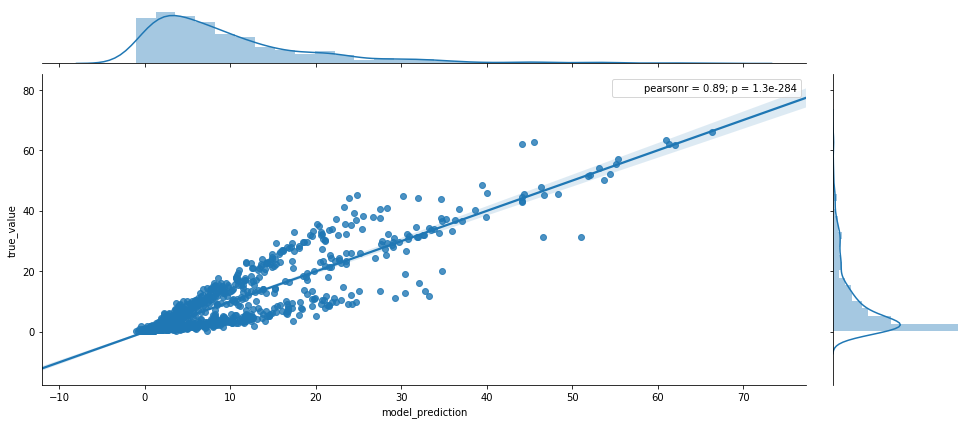

In [65]:
plot_joint_and_r_squared(xgb2)

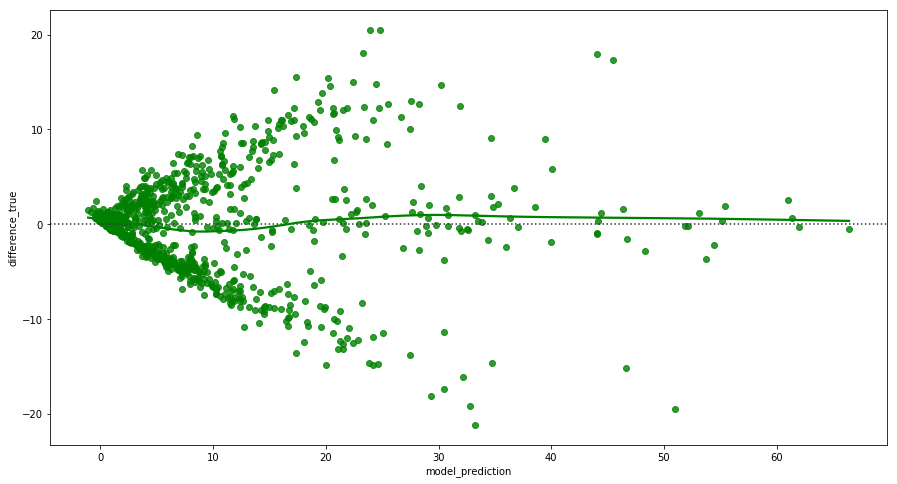

In [66]:
#This figure shows the residuals of the model with the x-axis containing the predicted value and the y-axis the
#difference between predicted and true. The residuals should be randomly distriburted and hover around 0 mean value
plot_residuals(xgb2)

# Dump the files to pickle

In [67]:
import pickle
from sklearn.externals import joblib
#this is to save the model 
joblib.dump(xgb.best, 'xgb_best_model.joblib') 
joblib.dump(xgb1.best, 'xgb_best_model.joblib') 
joblib.dump(xgb2.best, 'xgb_best_model.joblib') 
clf = joblib.load('filename.joblib') 

AttributeError: 'XGBRegressor' object has no attribute 'best'

# Extra: Further analysis of features
## Plot residuals and jointplot

These plots will show the performance of our model based on a jointplot where the x-axis contains the predicted S of the model and the y-axis shows the true value of S. The line is a linear regression line to show the pearson r score of this model

In [48]:
def Check_difference_residuals():
    prediction_model = (xgb.predict(X_test))
    df_x = X_test
    df_x['model_pred']=prediction_model
    df_x['model_true']=y_test
    df_x['model_resid']= (df_x['model_true']-df_x['model_pred']).round(0)
    return(df_x)


In [49]:
residual_df = Check_difference_residuals()
residual_df_grouped = residual_df.groupby(by='model_resid').mean()
residual_df_grouped[['L', 'mu', 'cvr', 'f', 'm', 'cs/cw']].plot()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

,L,mu,cvr,f,m,cs/cw,model_pred,model_true,model_resid
Inst ID,,,,,,,,,
5125,0,6,15,0.8,5,1,0.757905,4.2,3.0
8909,1,4,15,0.5,5,2,9.071942,3.8,-5.0
15195,2,10,1,0.2,6,2,2.233222,1.6,-1.0
3422,0,2,15,0.8,10,5,1.785442,0.5,-1.0
8099,1,2,15,0.8,6,10,-0.737471,1.1,2.0
6348,0,10,2,1.0,2,5,9.356120,2.8,-7.0
13794,2,4,2,0.8,4,1,26.404837,15.5,-11.0
15256,2,10,1,0.8,3,5,1.074899,2.5,1.0
15582,2,10,2,0.0,10,10,-0.378352,1.1,1.0
